In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [4]:
del file_to_pages

In [5]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [6]:
df_annotations_num_arms_known = df_annotations_num_arms_known.sample(1000)

In [7]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

# Train and evaluate the number of arms extractor

In [8]:
sys.path.append("../../front_end")
from util.page_tokeniser import tokenise_pages, tokenise_text, tokenise_text_and_lowercase

In [9]:
import spacy
from spacy.matcher import Matcher
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])



In [10]:
word2num = {'one': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'ten': 10,
 'eleven': 11,
 'twelve': 12,
 'thirteen': 13,
 'fourteen': 14,
 'fifteen': 15,
 'sixteen': 16,
 'seventeen': 17,
 'eighteen': 18,
 'nineteen': 19,
 'both': 2,
 'single': 2}

In [11]:
number_words = list(word2num)

In [12]:
for n in range(1, 20):
    word2num[str(n)]= n

In [13]:
numbers_above_3 = list([w for w in word2num if word2num[w] >= 3])

In [14]:
matcher = Matcher(nlp.vocab)
patterns = [ #[{"LIKE_NUM":True},  {"LOWER": {"IN": ["treatment", "study", "dose"]}, "OP":"?"}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
           [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["treatment", "study", "dose"]}}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
#            [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
             [{"LOWER":{"IN":list(word2num)}},{"LOWER":"-", "OP":"?"}, {"LOWER": {"IN": [ "armed"]}}]
]
matcher.add("arms", patterns)

In [15]:
doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=["5", "arms"])
matcher(doc)

[]

In [16]:
#tokenised_pages = [["5", "arms"]]
# if True:
def process(self, tokenised_pages: list) -> tuple:
    """
    Identify the trial phase.
    :param tokenised_pages: List of lists of tokens of each page.
    :return: The prediction (str) and a map from phase to the pages it's mentioned in.
    """

    tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

    phase_to_pages = {}

    for page_number, page_tokens in enumerate(tokenised_pages):
        doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=page_tokens)
        matches = matcher(doc)
        for word, start, end in matches:
            phase_number = doc[start:end]
            if phase_number not in phase_to_pages:
                phase_to_pages[phase_number] = []
            phase_to_pages[phase_number].append(page_number)

    phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

    prediction = 0
    if len(phase_to_pages) == 1:
        for word in phase_to_pages[0][0]:
            if word.text in word2num:
                prediction = word2num[word.text]
                break
    if prediction > 5:
        prediction = 5
                
    phase_to_pages = [(phrase.text, value) for phrase, value in phase_to_pages]

    return {"prediction": prediction, "pages": dict(phase_to_pages)}

In [17]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [18]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import make_pipeline

In [20]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True,
                             token_pattern=r'[a-z][a-z]+', 
                            
                            vocabulary={
                                "arm", "group", "subgroup", "cohort", "arms", "groups", "subgroups", "cohorts",
                    "randomise", "randomize", "randomisation", "randomization", "randomised", "randomized",
                    "placebo", "unblinded", "unblinding", "blinded", "blinding", "blind", "compare", "double",
                    "controlled", "control", "differences", "vs", "outcomes", "hypothesis", "experimental", "compared",
                    "effects", "variables", "variables", "ratio", "versus", "outcome", "monotherapy", "polytherapy", "proprietary",
                    "criterion", "healthy", "remission", "separately", "separate", "separated", "assay", "dosing", "dose", "doses",
                    "treatment", "treatments", "study", "studies", "either", "both"}
                            )
transformer = TfidfTransformer()

nb = MultinomialNB()
nb = ComplementNB()
model = make_pipeline(vectoriser, transformer, nb)

In [21]:
df_train.num_arms_clean.value_counts()

2.0    333
1.0    225
3.0    109
4.0     83
5.0     51
Name: num_arms_clean, dtype: int64

In [22]:
model.fit(df_train.text, df_train.num_arms_clean)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(token_pattern='[a-z][a-z]+',
                                 vocabulary={'arm', 'arms', 'assay', 'blind',
                                             'blinded', 'blinding', 'both',
                                             'cohort', 'cohorts', 'compare',
                                             'compared', 'control',
                                             'controlled', 'criterion',
                                             'differences', 'dose', 'doses',
                                             'dosing', 'double', 'effects',
                                             'either', 'experimental', 'group',
                                             'groups', 'healthy', 'hypothesis',
                                             'monotherapy', 'outcome',
                                             'outcomes', 'placebo', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('complementnb', ComplementNB())])

In [23]:
df_val["pred_num_arms_nb"]  = model.predict(df_val.text)

/tmp/ipykernel_9409/2554258759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms_nb"]  = model.predict(df_val.text)


In [24]:
df_val.pred_num_arms_nb.value_counts()

2.0    42
1.0    40
4.0     1
Name: pred_num_arms_nb, dtype: int64

In [25]:
def get_num_arms(text):
    toks = tokenise_text_and_lowercase(text)
    result = process(None, [toks])
    return result["prediction"]

In [26]:
def get_pages(text):
    toks = tokenise_text_and_lowercase(text)
    result = process(None, [toks])
    return result["pages"]

In [27]:
df_val["pred_num_arms_spacy"] = df_val.text.apply(get_num_arms)

/tmp/ipykernel_9409/3003238752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms_spacy"] = df_val.text.apply(get_num_arms)


In [28]:
df_val["pred_num_arms_spacy"].value_counts()

0    70
2    10
3     2
1     1
Name: pred_num_arms_spacy, dtype: int64

In [29]:
pred_num_arms = []
for i in range(len(df_val)):
    if df_val.pred_num_arms_spacy.iloc[i] > 0:
        pred = df_val.pred_num_arms_spacy.iloc[i]
    else:
        pred = df_val.pred_num_arms_nb.iloc[i]
    pred_num_arms.append(pred)
df_val["pred_num_arms"] = pred_num_arms
pred_num_arms= df_val["pred_num_arms"]

/tmp/ipykernel_9409/521656970.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms"] = pred_num_arms


In [30]:
df_val["pages"] = df_val.text.apply(get_pages)

/tmp/ipykernel_9409/1874208678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pages"] = df_val.text.apply(get_pages)


In [31]:
pred_num_arms

2907     1.0
11393    1.0
8242     1.0
7572     2.0
5234     2.0
        ... 
4323     2.0
8597     1.0
8598     2.0
3888     1.0
2327     2.0
Name: pred_num_arms, Length: 83, dtype: float64

In [32]:
pred_num_arms.value_counts()

2.0    43
1.0    37
3.0     2
4.0     1
Name: pred_num_arms, dtype: int64

In [33]:
num_arms_ground_truths = df_val.num_arms_clean

In [34]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.5421686746987951


''

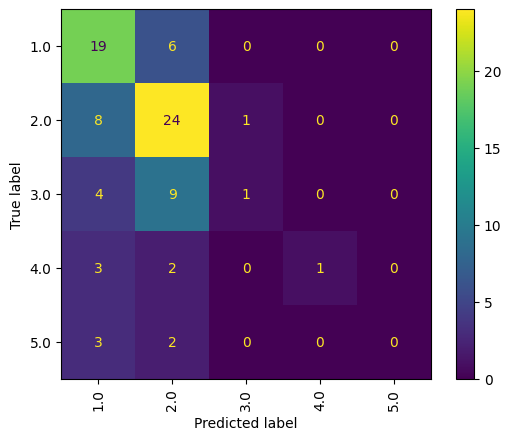

In [35]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [36]:
accuracy_score(num_arms_ground_truths[pred_num_arms > 0], pred_num_arms[pred_num_arms > 0])

0.5421686746987951

In [37]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,num_arms_clean,pred_num_arms_nb,pred_num_arms_spacy,pred_num_arms,pages
2907,24_NCT02886624_Prot_SAP_000.pdf,NCT02886624,val,1.0,NaN,Phase 2,Drug,FR,1,\nDocument: Protocol \n\nDocument title: \n\n...,1.0,1.0,0,1.0,{}
11393,95_NCT02869295_Prot_000.pdf,NCT02869295,val,1.0,NaN,Phase 1/Phase 2,Drug,US,0,\nProtocol No. 15-214-01 Amendment 4.0 NKTR-21...,1.0,1.0,0,1.0,{}
8242,69_NCT01896869_Prot_SAP_000.pdf,NCT01896869,val,2.0,NaN,Phase 2,DrugBiological,US,1,"\ni \n \n\nOfficial Title: A Phase 2, Multicen...",2.0,1.0,0,1.0,"{'both treatment arms': [0], 'two treatment ar..."
7572,63_NCT02804763_Prot_000.pdf,NCT02804763,val,4.0,NaN,Phase 2,Drug,"US,BG,CL,CO,DE,HU,MX,PE,PL,RO,RU,ES,UA",0,\nUCB 14 Dec 2016\nClinical Study Protocol Dap...,4.0,2.0,0,2.0,{}
5234,44_NCT00824044_Prot_000.pdf,NCT00824044,val,2.0,NaN,Phase 4,Drug,US,0,\nVersion Date: 11/30/09 1 \n\nQEEG Predictors...,2.0,2.0,0,2.0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,36_NCT02873936_Prot_000.pdf,NCT02873936,val,3.0,NaN,Phase 3,Drug,"US,AR,AU,BE,FR,DE,HU,IL,JP,KR,MX,PL,ES,CH,GB,I...",0,\n \nCLINICAL STUDY PROTOCOL\n\nStudy Title...,3.0,2.0,0,2.0,{}
8597,72_NCT02870972_Prot_000.pdf,NCT02870972,val,5.0,NaN,Phase 2,Drug,"AU,AT,CA,DK,DE,HU,IT,MK,ES,CH,GB,MK",0,\nProtocol BCX7353-203 BioCryst Pharmaceutical...,5.0,1.0,0,1.0,{}
8598,72_NCT02876172_Prot_000.pdf,NCT02876172,val,1.0,NaN,Phase 1/Phase 2,Drug,US,0,\nStudy Synopsis \n \n\nA Phase 1/2 Open-Label...,1.0,2.0,0,2.0,{}
3888,32_NCT03843632_Prot_SAP_000.pdf,NCT03843632,val,1.0,NaN,Phase 3,Biological,RU,1,\nOfficial Protocol Title: \n\nNCT number: \nD...,1.0,1.0,0,1.0,{}


In [38]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Strongest predictors for class 0

0	remission
1	dose
2	separated
3	studies
4	doses
5	dosing
6	cohort
7	assay
8	treatment
9	proprietary
10	study
11	either
12	versus
13	both
14	outcome
15	subgroups
16	monotherapy
17	treatments
18	effects
19	hypothesis
20	separately
21	outcomes
22	separate
23	criterion
24	control
25	compared
26	ratio
27	experimental
28	cohorts
29	healthy
30	controlled
31	group
32	differences
33	arm
34	variables
35	groups
36	vs
37	double
38	randomized
39	compare
40	blinding
41	blinded
42	subgroup
43	placebo
44	blind
45	randomised
46	arms
47	randomization
48	polytherapy
49	unblinding
50	randomise
51	unblinded
52	randomize
53	randomisation
Strongest predictors for class 1

0	randomisation
1	randomization
2	compare
3	subgroup
4	randomize
5	unblinding
6	randomized
7	blinded
8	placebo
9	vs
10	arms
11	blind
12	randomised
13	blinding
14	unblinded
15	variables
16	experimental
17	outcomes
18	double
19	ratio
20	compared
21	controlled
22	hypothesis
23	group
24	arm
25	effects
26	group